###### Content under Creative Commons Attriubtion license CC-BY 4.0, (c)2014 Matt Bornemeier, for Prof. L. A. Barba's MAE 6286 course at The George Washington University. Portions of the code adopted from the #numericalmooc materials, also under CC-BY.

## Lions, and Tigers, and 4th Order PDE's! Oh, My!

### Euler-Bernoulli Beam Equation

Welcome back! In this notebook we will study an equation of higher order: the Euler-Bernoulli beam equation. It is fourth-order in space, second-order in time and is similar  to the wave equation but it is not hyperbolic. Interestingly enough, it isn't parabolic either. What is it? What does it do? What does it look like?? We will learn the answers to these questions and more in this lesson.

Let's get started!

But first: do you remember how to print equations in Sympy? Did you forget? We will revisit this valuable (and aesthetically pleasing) skill in this lesson.

In [1]:
import sympy
from sympy import init_printing
init_printing()

First things first: let's define our problem.

The Partial Differential Equation (PDE) that governs transverse vibrations in a beam is the Euler-Bernoulli equation. For this model, we will only deal with 1-D vibrations in the lengthwise direction (the x-direction).


\begin{equation}PDE:\frac{\partial^2 w(x,t)}{\partial t^2} + \frac{E I}{\rho A} \frac{\partial^4 w(x,t)}{\partial x^4} = 0\end{equation}

Let's say we have a steel beam of length $L$ ($m$), density $\rho$ ($kg/m^3$), cross-sectional area $A$ ($m^2$), Young's Modulus of Elasticity $E$ ($N/m^2$), and area moment of inertia $I$ ($m^4$). Let's also assume that the beam is of uniform density, cross-sectional area and elasticity. 



Because our PDE is 4th order in space we need four, count them, four Boundary Conditions (BC's). They are dependent on how the beam is fixed at the boundary. For our particular model imagine that the beam is affixed to the wall -- it does not move at the wall, so it has zero displacement at the ends of the beam. Furthermore, the slope at these same points wall is also zero. This is an example of a "fixed" or "clamped" boundary condition. Because it is attached this way on both ends, we say the beam is "clamped-clamped" or "fixed-fixed."



\begin{eqnarray}BC's:&&{w(0,t)} =0\ ,  & 
&\frac{\partial w(0,t)}{\partial x} = 0\ ,  &
&{w(L,t)} = 0\ , &
&\frac{\partial w(L,t)}{\partial x}=0 \end{eqnarray} 

We also need two Initial Conditions (IC's) -- initial posiiton and initial velocity. We will take the initial velocity to be zero and the initial position to be some displacement which is a function of x.

\begin{eqnarray}IC's:&{w(x,0)} = f(x),  & 
&\frac{\partial w(x,0)}{\partial t} = 0\ \end{eqnarray} 

OK, now we have the problem defined. Now what? We've never discretized a 4th order equation before? Can we do this?

Of course we can -- it's easy. We'll even code the function with array operations. 

Let's use a central difference in time and a central difference in space. Both are second order accurate, so we can expect a second order accuracy in our model. John Strikwerda (1989) proposed this model for the Euler-Bernoulli Beam equation$^5$:

\begin{equation}\frac{w_i^{n+1} - 2w_{i}^n + w_{i}^{n-1}}{\Delta t^2} = -\frac{E I}{\rho A}\frac{(w_{i+2}^n - 4w_{i+1}^n + 6w_{i}^n - 4w_{i-1}^n + w_{i-2}^n)}{\Delta x^4} \end{equation}

If we perform a bit of algebra and rearrange the equation:

\begin{equation} w_i^{n+1} =  -\frac{E I\Delta t^2}{\rho A \Delta x^4 }(w_{i+2}^n - 4w_{i+1}^n + 6w_{i}^n - 4w_{i-1}^n + w_{i-2}^n)  + 2w_{i}^n - w_{i}^{n-1}\end{equation}

And for the sake of simplicity, let's rename the coefficient $EI/ρA$ to $b$:

\begin{equation} w_i^{n+1} =  -\frac{b^2\Delta t^2}{\Delta x^4 }(w_{i+2}^n - 4(w_{i+1}^n + w_{i-1}^n)+ 6w_{i}^n + w_{i-2}^n)  + 2w_{i}^n - w_{i}^{n-1}\end{equation}

Did we forget anything? Oh yeah, the CFL. What is it? If we use von Neumann stability analysis$^5$, we find that in order for this scheme to stable the following must be true:

\begin{equation}\frac{E I\Delta t^2}{\rho A \Delta x^4 } \le 0.5\end{equation}

Now let's initialize our code. 

In [2]:
import numpy;
import matplotlib.pyplot as plt;
%matplotlib inline
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

In [3]:
sigma = .50;                 #CFL condition must be less than or equal to .5 to ensure stability
nx = 80                      #number of points along the beam

rho = 8000.                  #density of steel (kg/m^3)
r = 0.3048/2.                #radius (m) This is a radius of 6 inches, or a diameter of 1 ft
I = 0.5*numpy.pi*(r)**4      #Area moment of inertia (m^4)
E = 200.*(10.**9)            #Young's Modulus for steel (N/m^2) or (Pa) 
A = numpy.pi * (r)**2        #Cross-Sectional Area of the circular beam (m^2)
b = numpy.sqrt((E*I)/(rho*A))#redefine the coefficient as b^2

L = 3.048                    #Length of the rod (m), 10 feet
dx = (L/(nx))                #size of spatial step
dt = (sigma*(dx)**2)/b       #size of timestep, with CFL defensively coded in
nt = 300                    #number of time steps
totaltime = dt*nt            #how long (s) we are running the simulation


The values of density and Young's Modulus are both accurate values for a steel beam. The beam is ten feet long with a radius of six inches, and from these dimensions we can also find the cross-sectional area and moment of inertia of the beam.

Notice that because of the $(\Delta x)^4$ term in our equation and the CFL of $1/2$, we are stuck with using a very small timestep. We will discuss this more later.

For our initial position IC, let's make some sort of displacement that is similar to a force acting upward at $L/4$ and another force acting downward at $3L/4$ and then released at time $t=0$. We can approximate this as a polynomial by solving for four points on the curve of the beam and running it in a loop for the number of spatial points.

Remember that everything is in meters, so .005 meters is approximately 0.2 inches.

In [4]:
# IC's
w = numpy.zeros((nt,nx))
w_i = numpy.zeros(nx)
w_ii = numpy.zeros(nx)   #initial velocity is zero 
                         #this equation


# simulating a load on the end of the beam before time = 0, 
# some sort of continuous bending ploynomial function. This was arbitrarily chosen.

for i in range(nx):
    w_i[i] = (.0175)*(i*dx) - (.01722)*((i*dx)**2) + (.003767)*((i*dx)**3)
    
w_i[0] = 0
w_i[nx-1] = 0
w_i[1] = 0
w_i[nx-2] = 0

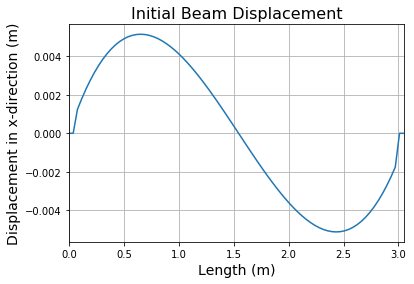

In [5]:
x = numpy.linspace(0,L,nx)
plt.xlim(0.0,3.048)
plt.plot(x,w_i)
plt.xlabel('Length (m)', fontsize=14)
plt.ylabel('Displacement in x-direction (m)', fontsize=14)
plt.grid(True)
plt.title('Initial Beam Displacement', fontsize=16);

We need to generate a first step though because our discretization has a $w_i^{n-1}$ term in it. We can do this by performing a three-term Taylor Series Expansion of $w(x,\Delta t)$ by using the initial conditions for the position and velocity and setting the third term equal to the other side of the PDE.$^5$

\begin{equation}w(x,\Delta t) = w(x,0) + \Delta t \frac{\partial w(x,0)}{\partial t} + \frac{1}{2}\Delta t^2 \frac{\partial^2w(x,0)}{\partial t^2} + O(\Delta t^3) \end{equation}

where \begin{equation}\frac{\partial^2w(x,0)}{\partial t^2} = -\frac{E I}{\rho A} \frac{\partial^4 w(x,0)}{\partial x^4} \end{equation}

Cool trick, Mr. Strikwerda!

Now let's define our function.

In [6]:
def ebd(b, dt, dx, w_i, w_ii,w):
    """Solves the Euler-Bernoulli beam equation with second-order central 
    second difference in time and second-order central fourth difference in space.
    
    Paremeters:
    ----------
    b:  float
        coefficient of sqrt (EI/ρA)
    
    dt: float 
        time step size
    
    dx: float
        mesh size
        
    w_i: array of float
         initial position IC
    
    w_ii: array of float
          initial velocity IC
        
    Returns:
    -------
    w:  array of float
        Position of center of beam for dx spatial steps in nt steps in time 
        
    """
    #Initialize data storage arrays
    w_dummy = numpy.zeros(nx)
    w_firststep = numpy.zeros(nx)
    w_firststep = w_i
    
    #Generate first step of the simulation
    w_firststep[2:-2] = w_i[2:-2] + dt*w_ii[2:-2] + (.5 * -(b**2.)*(dt**2.))*(w_i[4:] - 4.*w_i[3:-1] + 6.*w_i[2:-2] - 4.*w_i[1:-3] + w_i[:-4])
    w[0,:] = w_i.copy()
    w[1,:]= w_firststep.copy()
    w_dummy = w_firststep.copy()
        
    #Run simulation for nt time steps over nx points of the beam.
    for i in range(int(nt-2)):
        w[i+2,2:-2] = w_dummy[2:-2]*(2. - (6.*b**2.*dt**2.)/(dx**4)) - (((b**2)*(dt**2))/(dx**4))*(w_dummy[4:] - 4.*(w_dummy[3:-1] + w_dummy[1:-3]) + w_dummy[:-4]) - w_i[2:-2]
        
        w_i = w_dummy.copy()
        w_dummy = w[i+2,:].copy()
        w[i+2,0] = 0
        w[i+2,1] = 0
        w[i+2,-1] = 0
        w[i+2,-2] = 0  

Note that the indices of the arrays are $w$[2:-2] because we have a $w_{i-1}$ and $w_{i+1}$ term in the mix. But you already knew that, didn't you?

Also note that $w_i$ has now become the $w_i^{n-1}$ term in the loop after it's primary purpose as the initial condition. Efficient code or too confusing? You decide.

Let's execute our ebd function and run the simulation.

In [7]:
ebd(b,dt,dx,w_i,w_i,w)


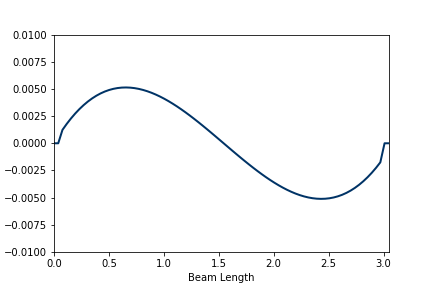
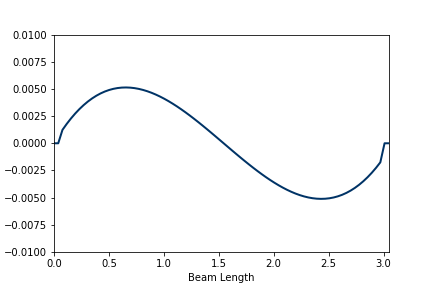
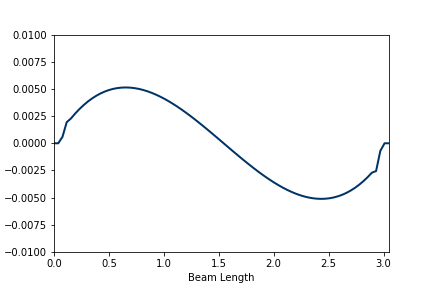
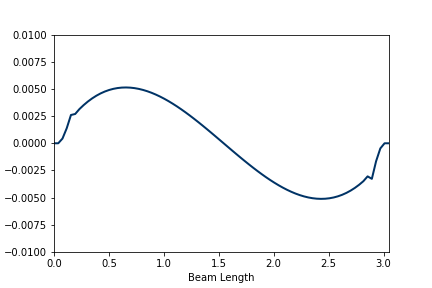
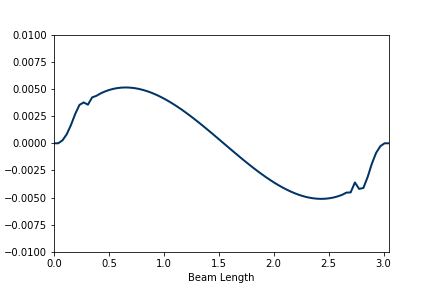
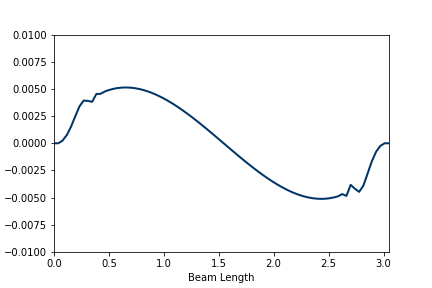
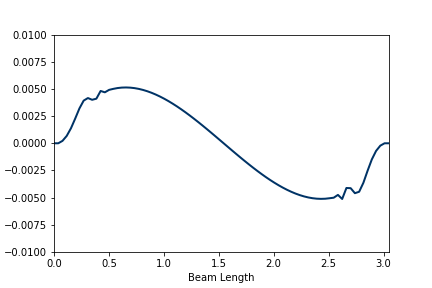
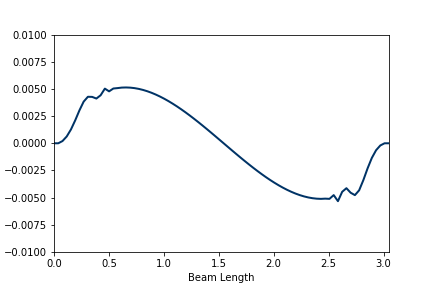
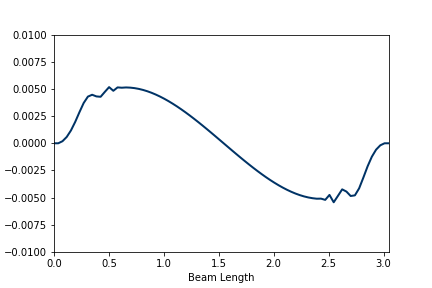
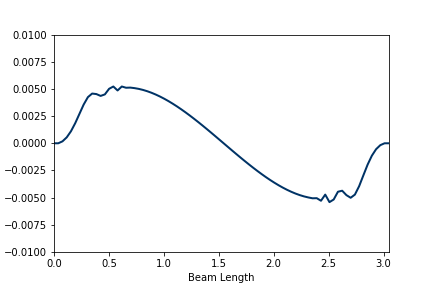
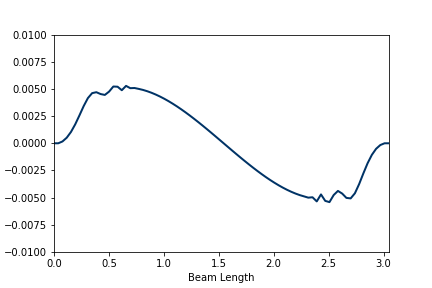
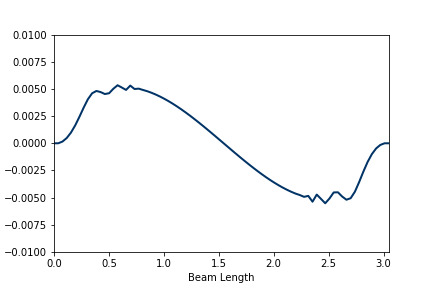
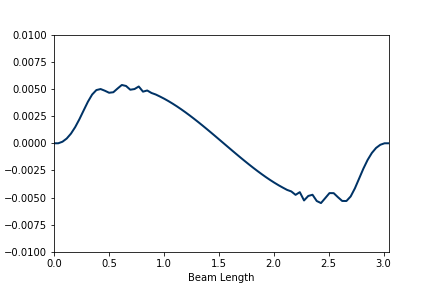
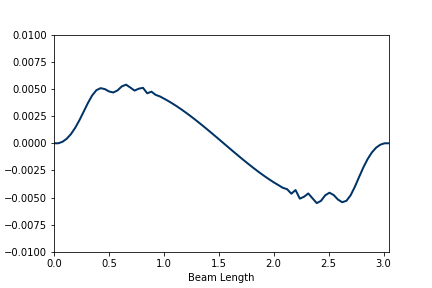
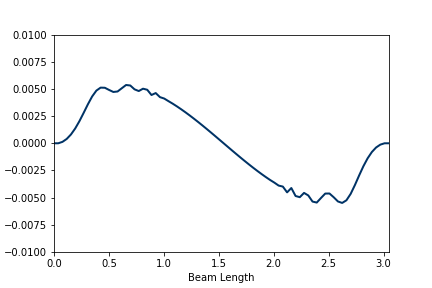
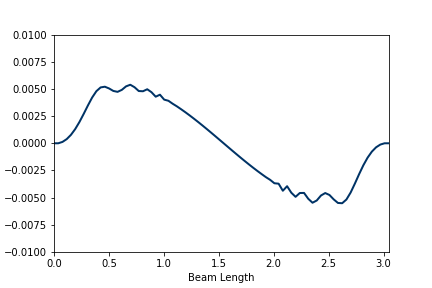
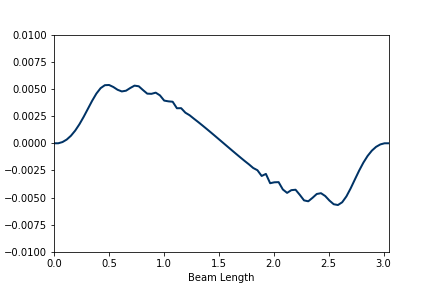
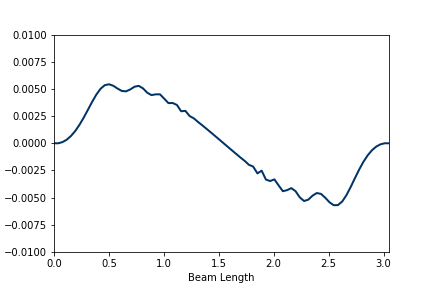
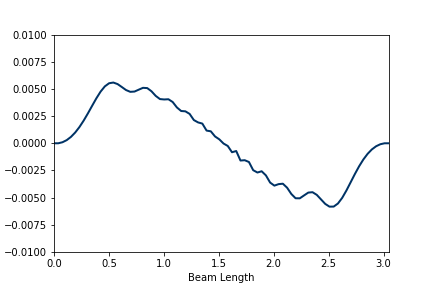
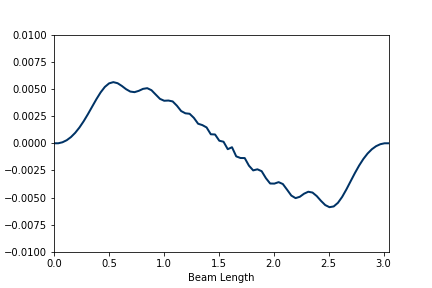
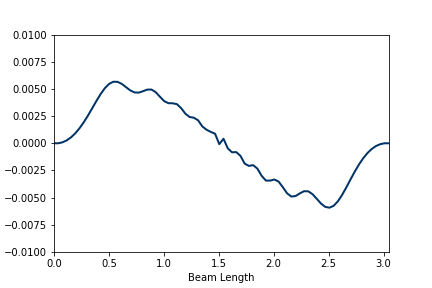
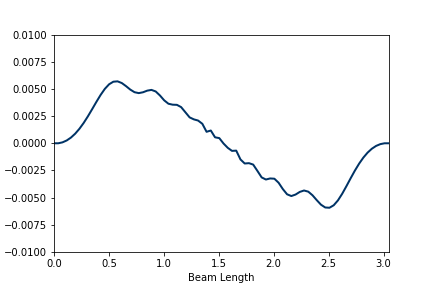
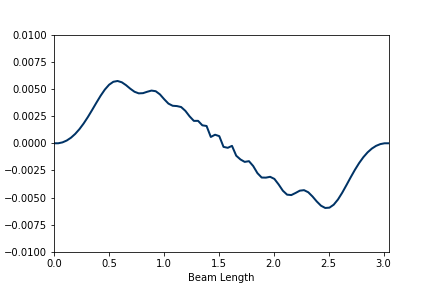
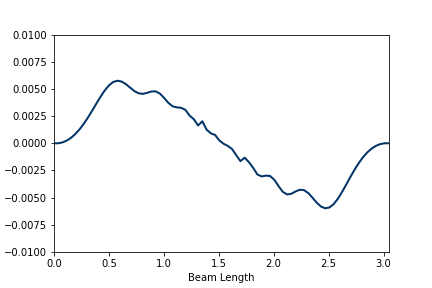
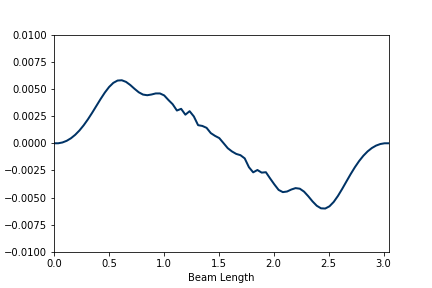
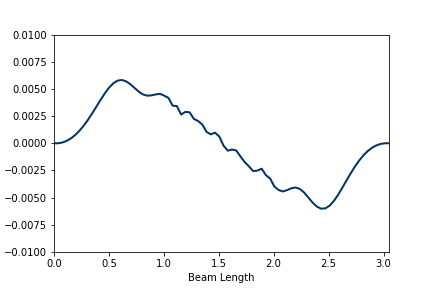
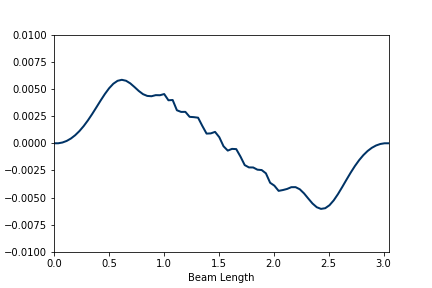
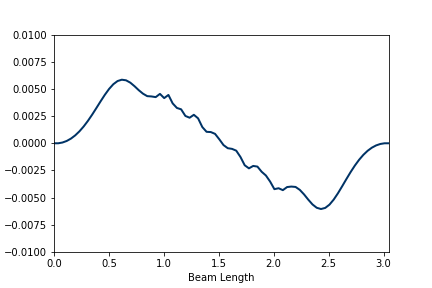
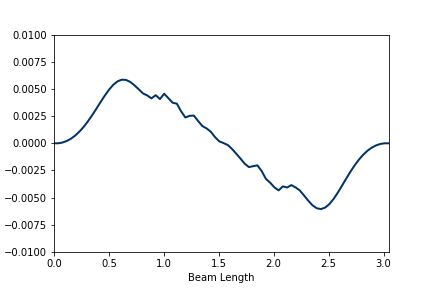
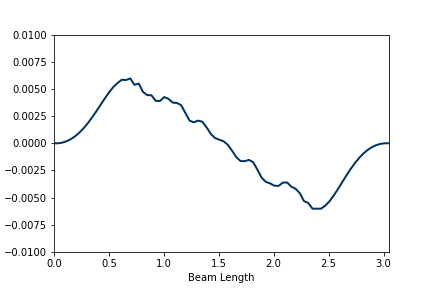
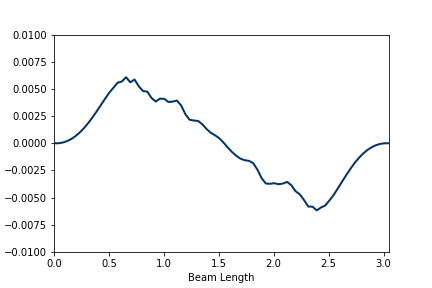
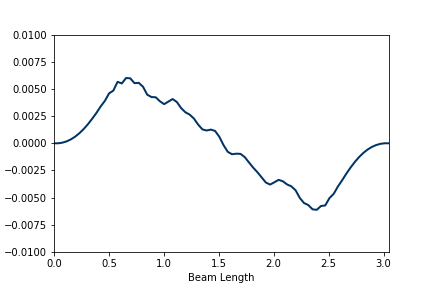
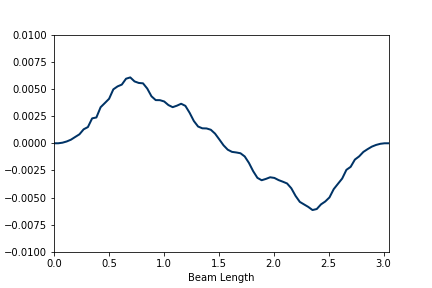
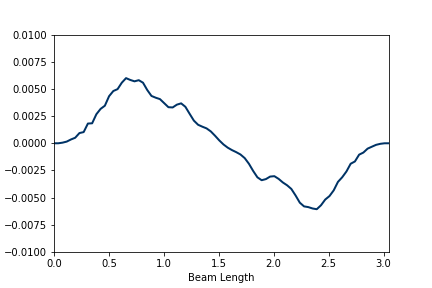
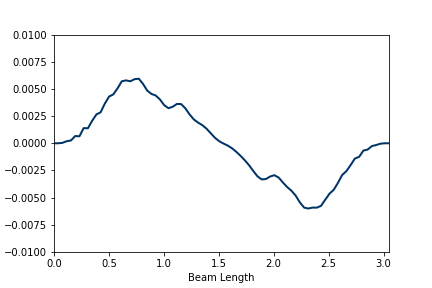
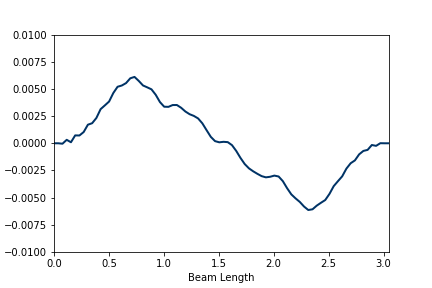
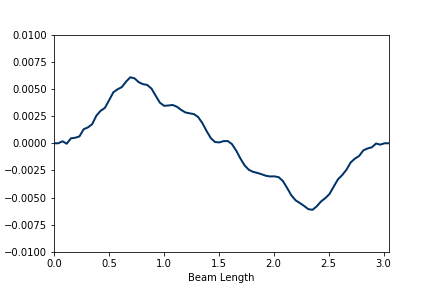
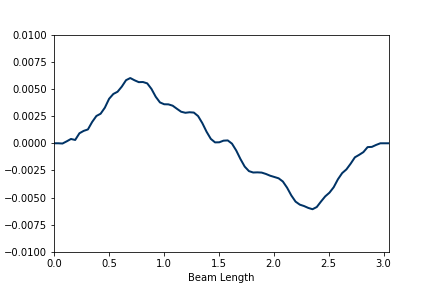
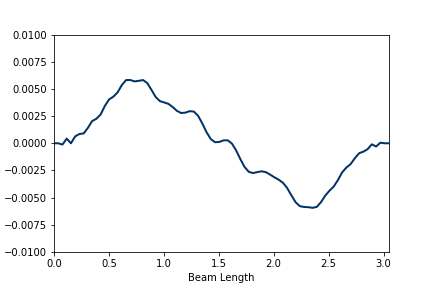
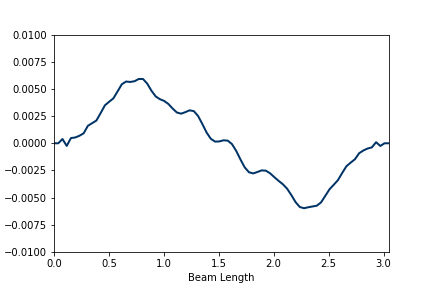
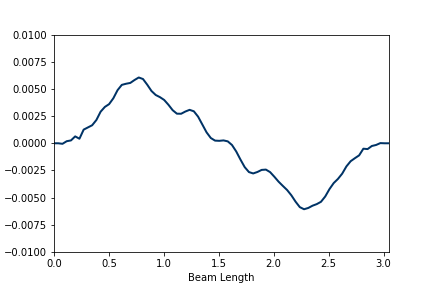
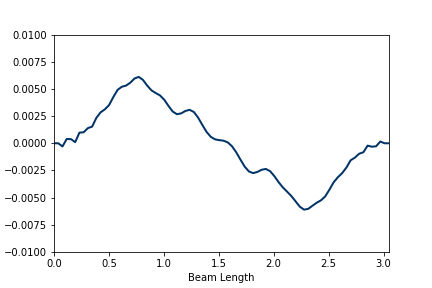
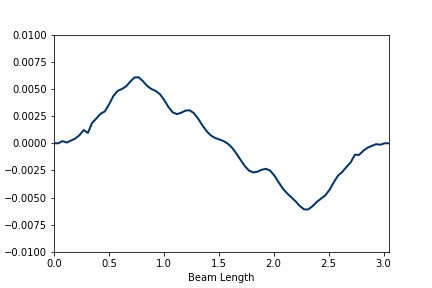
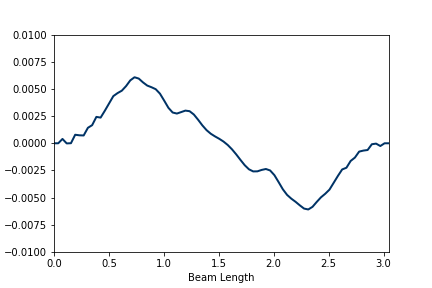
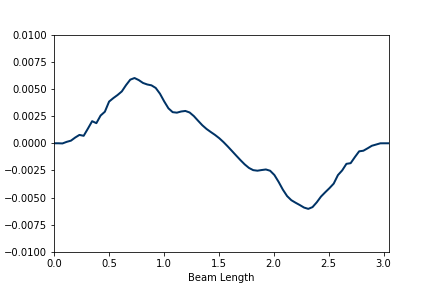
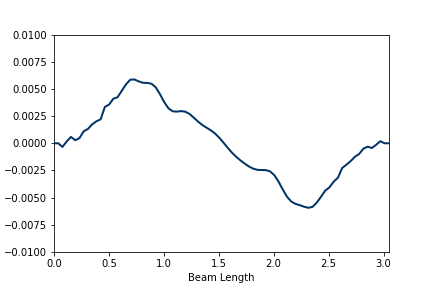
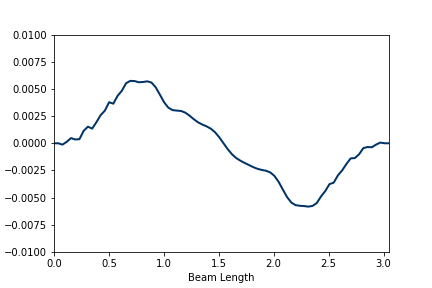
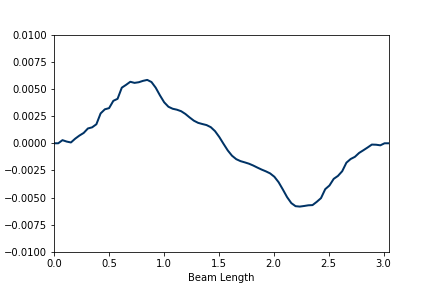
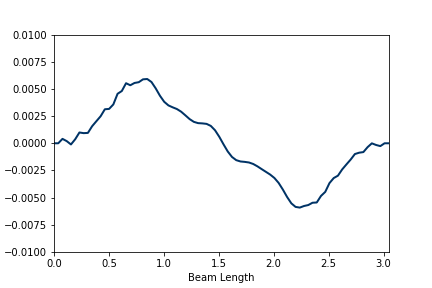
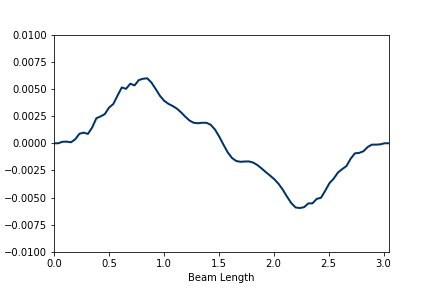
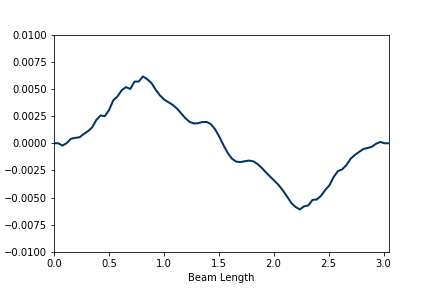
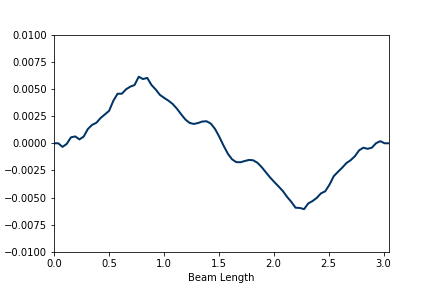
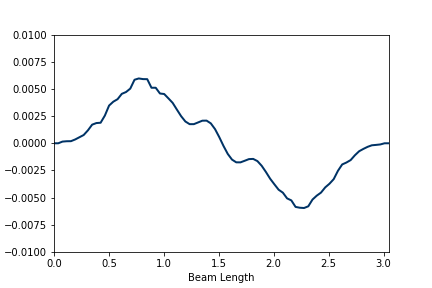
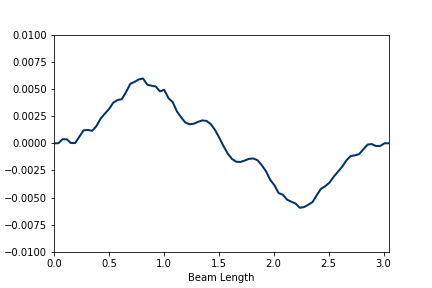
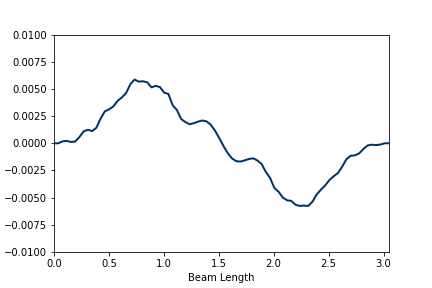
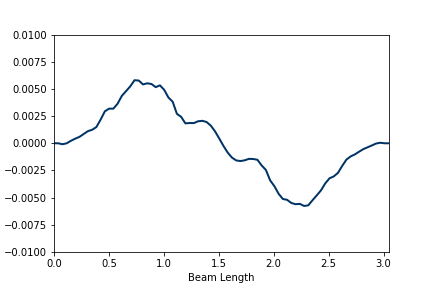
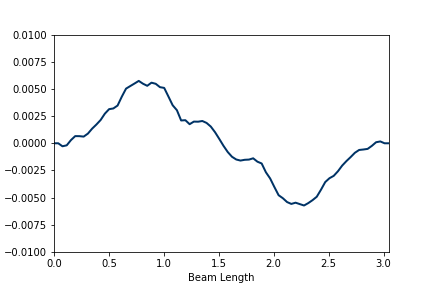
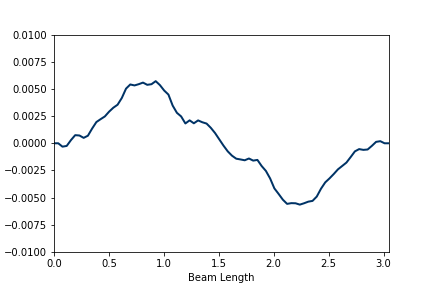
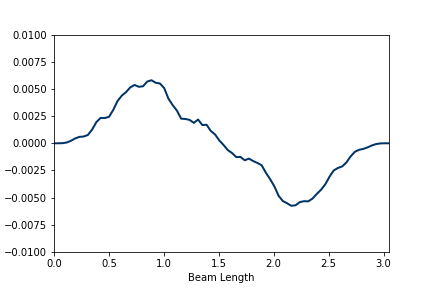
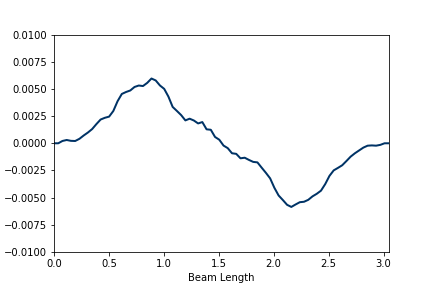
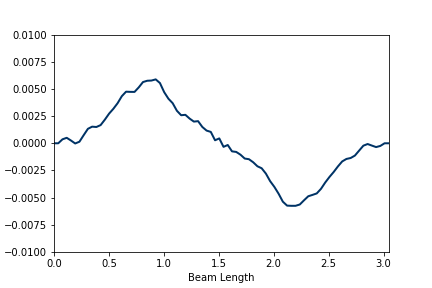
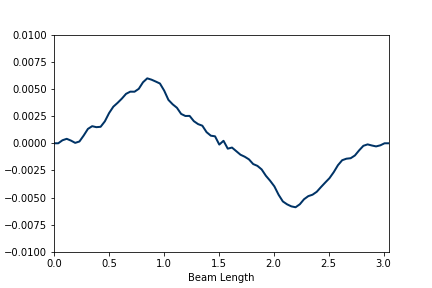
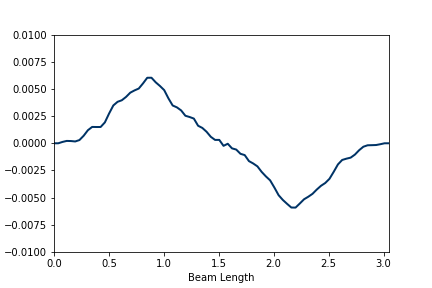
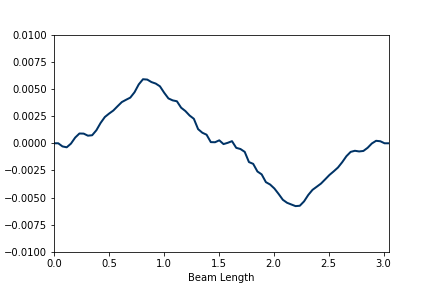
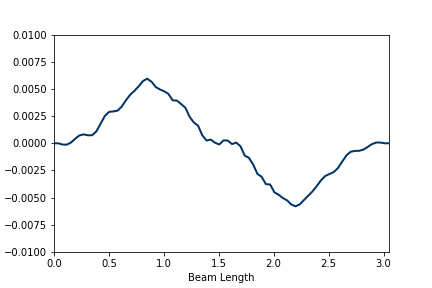
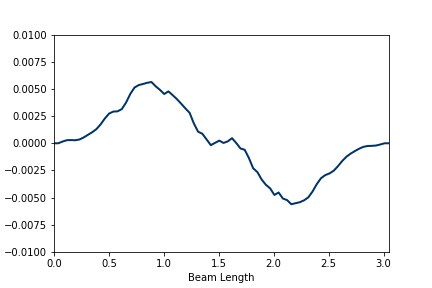
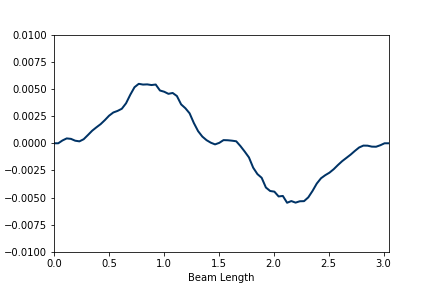
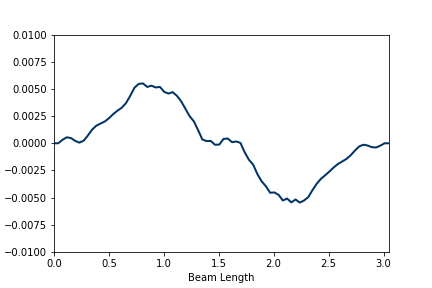
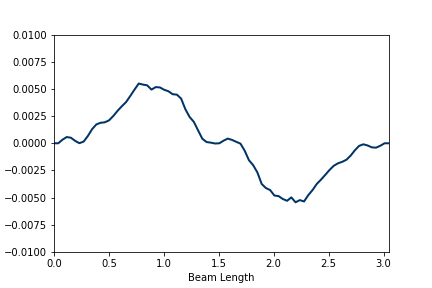
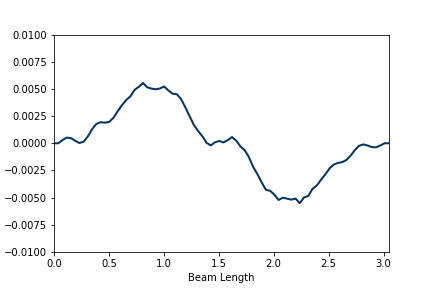
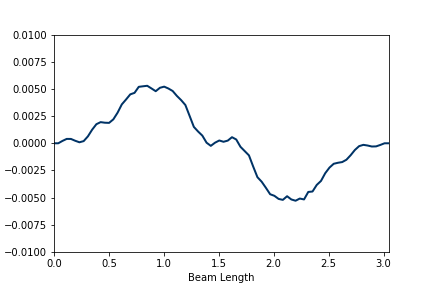

In [8]:
fig = plt.figure();
ax = plt.axes(xlim=(0,3.048),ylim=(-.01,.01),xlabel=('Beam Length'),ylabel=('Beam Displacement'));
line, = ax.plot([],[],color='#003366', lw=2);

def animate(frame):
    x = numpy.linspace(0,L,nx)
    y = w[frame,:]
    line.set_data(x,y)
    return line,

anim = animation.FuncAnimation(fig, animate, frames=nt-1, interval=50)
display_animation(anim, default_mode='once')

Wow! Is that cool or what? Notice all of the 'wiggles' from our fourth order PDE? Do you see some of the bigger waves bouncing off of the boundary equations and interacting with the smaller wiggles? There is certainly a lot going on here.

Remember how our timesteps were small? The whole length of this simulation in time is only 0.404 ms ! This beam is vibrating quite quickly when you think about it. Does that make sense physically? Remember steel has a very large value for $E$.

Now lets talk a little more about our PDE. 

\begin{equation}\frac{\partial^2 w}{\partial t^2} + \frac{E I}{\rho A} \frac{\partial^4 w}{\partial x^4} = 0\end{equation}

We can actually solve this equation by hand (analytically) which gives us, among other things, the liberty to adjust our IC in a special way.

We can use separation of variables on our PDE:

\begin{equation}w(x,t) = X(x)\Theta(t)\end{equation}

\begin{equation}X(x)\Theta''(t)+\frac{EI}{\rho A}X''''(x)\Theta(t) = 0 \end{equation}

\begin{equation}\frac{\Theta''(t)}{\Theta(t)} = -\frac{EI}{\rho A}\frac{X''''(x)}{X(x)} = -\omega^2\end{equation}

For the x variable this gives us:

\begin{equation} X''''(x)  -\frac{\rho A \omega^2}{E I}X(x) = 0\end{equation}

Renaming the coefficient on X(x) to $\beta^4$:

\begin{equation} X''''(x)  -\beta^4X(x) = 0\end{equation}

This yields a general solution in $x$ of:

\begin{equation} X(x) = c_1 \sin(\beta x) +  c_2 \cos(\beta x) +  c_3 \sinh(\beta x) +  c_4 \cosh(\beta x)\end{equation}

and a general solution in $t$ of:

\begin{equation}\Theta(t) = c_5 \cos(\omega t) + c_6 \sin(\omega t)\end{equation}

Applying our BC's to the $X(x)$ equation we can get a system of four equations. It looks like this:

\begin{align}\left[ \begin{array}{cccccc}
0 & 1 & 0 & 1  \\
\beta & 0 & \beta & 0 \\
\sin(\beta L) &  \cos(\beta L) &  \sinh(\beta L)& \cosh(\beta L) \\
\beta \cos(\beta L) & -\beta \sin(\beta L) & \beta \cosh(\beta L) & \beta \sinh(\beta L)\\
\end{array} \right]
 \left[ \begin{array}{c} 
 c_1 \\ c_2 \\ c_3 \\ c_4\end{array} \right]
 =
 \begin{bmatrix}
  0\\
  0\\
  0\\
  0\\
 \end{bmatrix}
 \end{align} 

The above matrix can be reduced to the following:

\begin{align}\left[ \begin{array}{cccccc}
\sinh(\beta L) - \sin(\beta L) & \cosh(\beta L) - \cos(\beta L)\\
-\cosh(\beta L) + \cos(\beta L) & \sinh(\beta L) + \sin(\beta L)\\
\end{array} \right]
 \left[ \begin{array}{c} 
 c_1 \\ c_4\end{array} \right]
 =
 \begin{bmatrix}
  0\\
  0\\
 \end{bmatrix}
 \end{align} 

From these two equations we can get the ratio of constants:

\begin{equation}\frac{c_1}{c_4} = \sigma = \frac{\cosh(\beta L) - \cos(\beta L)}{\sinh(\beta L) - \sin(\beta L)} \end{equation}

And by setting the determinant equal to zero, we get the mode shape: 

\begin{equation}\cos(\beta L)\cosh(\beta L) = 1\end{equation}

Now let's talk a little bit about the idea of mode shapes.

A beam that is vibrating along a continuum of points has an infinite number of natural frequencies and mode shapes that correspond to the infinite number of eigenvalues that solve the analytical equation. What does this mean? It means that for the infinite number of values of $\beta_n$ that solve our equation, each corresponds to a natural frequency, $\omega_n$.


This is a well-studied equation and as a result many textbooks$^{3,4}$ have tabulated values for the frequencies, $\omega_n$ = 1,2,3,4,5,...,n .

For our model let's say we want to activate only the sixth mode of this beam. We need to solve for $\beta_6$ and $\omega_6$. To do this we can look at the characteristic equation $\cos(\beta L)\cosh(\beta L) = 1$ . For every value of $\beta L$ that solves the equation, we have an eigenvalue...but we only want the sixth-occuring such solution. Numerically we can solve this, or we can look it up in a table$^3$:

$\beta L = \frac{(2n + 1)\pi}{2}$ and $n = 6$ yields a value of $\beta_6 L = \frac{13\pi}{2}$.

Remembering that: $\frac{\rho A \omega_6^2}{E I} = \beta_6^4$    and    $L$ = 3.048, we can solve for $\omega_6$. Now we can plug these back into our mode shape equation that we found earlier, where $\sigma$ represents the ratio of coefficients $c_1/c_4$. For our specific case (the sixth mode):

\begin{equation} \sigma_6 = \frac{\cosh(\beta_6 L) - \cos(\beta_6 L) }{\sinh(\beta_6 L) - \sin(\beta_6 L)} \end{equation}

Now we can finally develop our IC for the sixth mode shape:

\begin{eqnarray}{w(x,0)} = .005(\cosh\beta_6x - \cos\beta_6x - \sigma_6(\sinh\beta_6x- \sin\beta_6x )\end{eqnarray} 


Any guesses what this will look like? Note that the waveform has an amplitude of .005m.

Let's try it.

In [9]:
n=6.;      #Mode number to activate. We choose this as an independent variable.

b_n = ((2.*n+1)*numpy.pi)/(2.*L)     #beta_n
w_n = (b_n**2.)*numpy.sqrt((E*I)/(rho*A))   #Natural frequency, omega_n
sigma_n = (numpy.cosh(b_n*L) - numpy.cos(b_n*L))/(numpy.sinh(b_n*L)-numpy.sin(b_n*L))  #ratio of coefficients

In [10]:
# IC's
w = numpy.zeros((nt,nx))
w_i = numpy.zeros(nx)
w_ii = numpy.zeros(nx)         #initial velocity is zero

#Apply mode shape to initial position IC 
for i in range(nx):
    w_i[i] = .005*(numpy.cosh(b_n*(i*dx)) - numpy.cos(b_n*(i*dx)) - sigma_n*(numpy.sinh(b_n*(i*dx)) - numpy.sin(b_n*(i*dx)) ) )

w_i[0] = 0
w_i[nx-1] = 0
w_i[1] = 0
w_i[nx-2] = 0

In [11]:
x = numpy.linspace(0,L,nx)
plt.xlim(0.0,3.048)
plt.plot(x,w_i)
plt.xlabel('Length (m)', fontsize=14)
plt.ylabel('Displacement in x-direction (m)', fontsize=14)
plt.grid(True)
plt.title('Initial Beam Displacement', fontsize=16);

In [12]:
ebd(b,dt,dx,w_i,w_i,w)


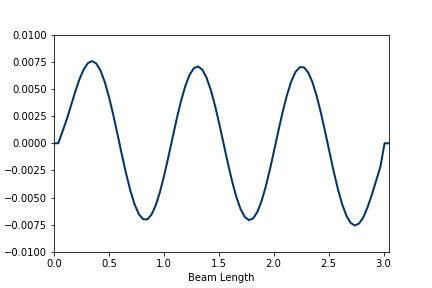
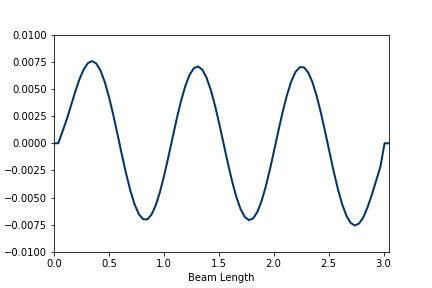
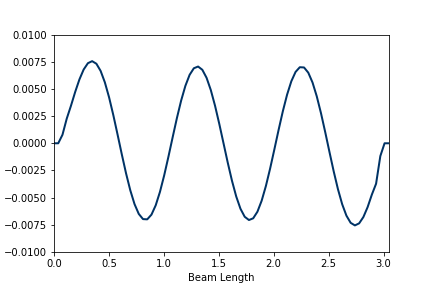
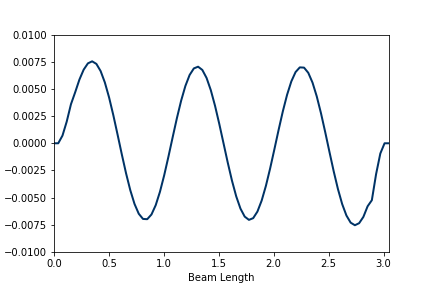
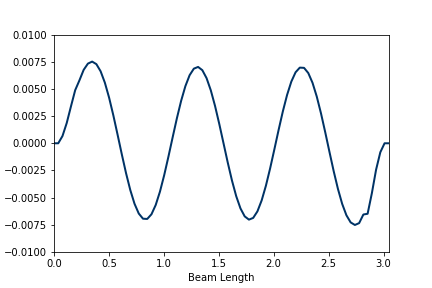
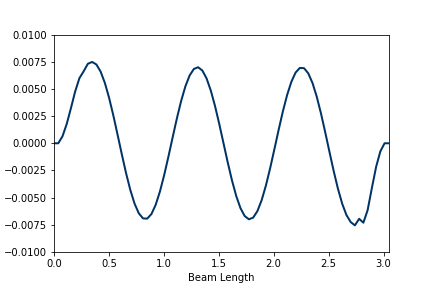
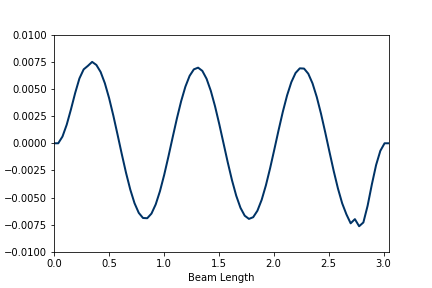
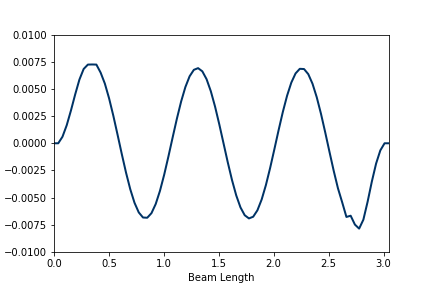
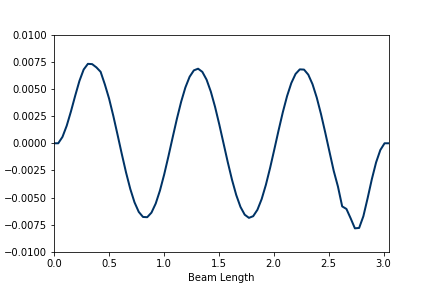
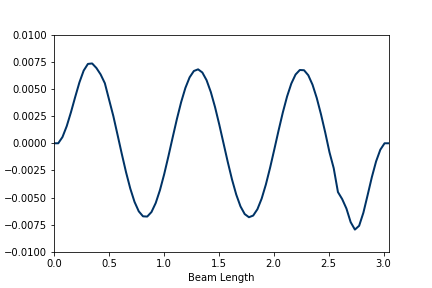
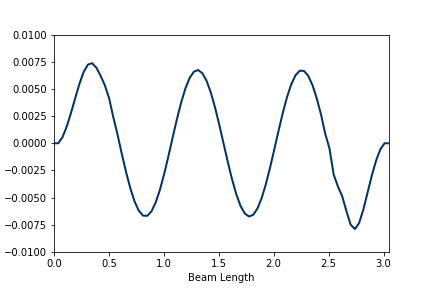
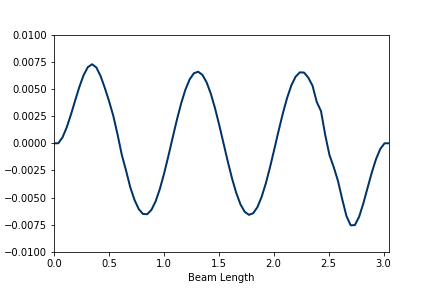
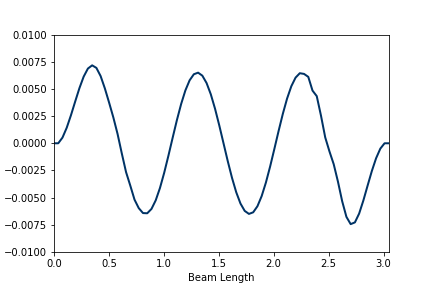
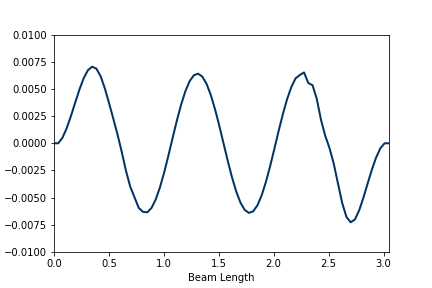
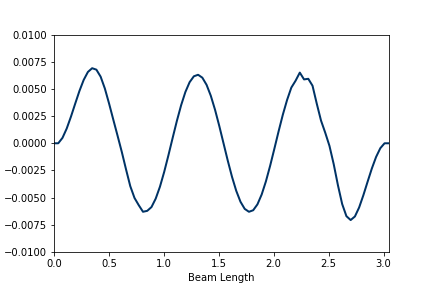
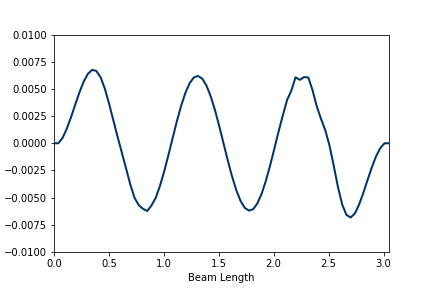
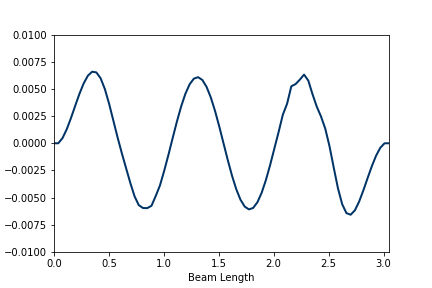
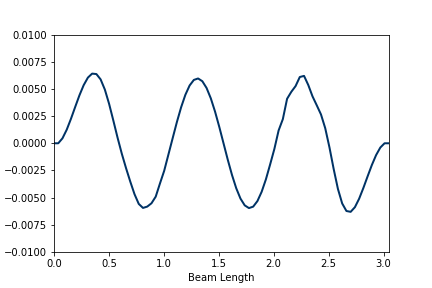
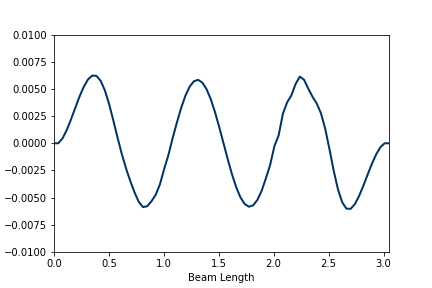
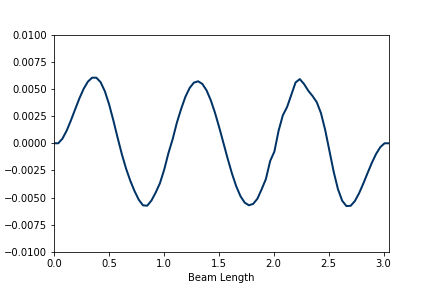
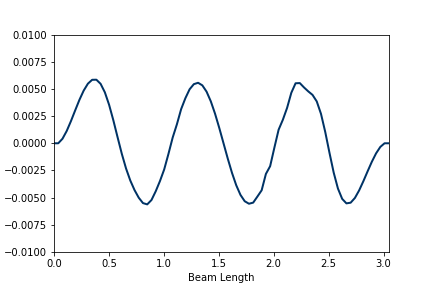
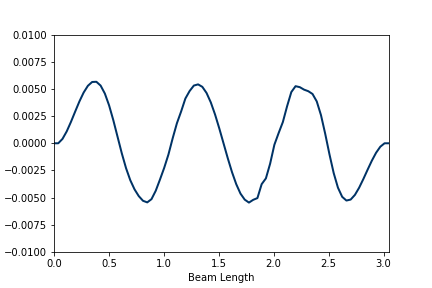
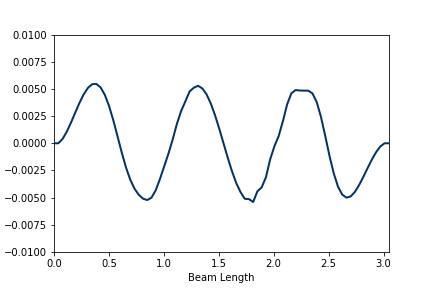
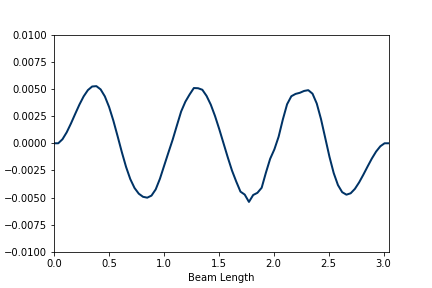
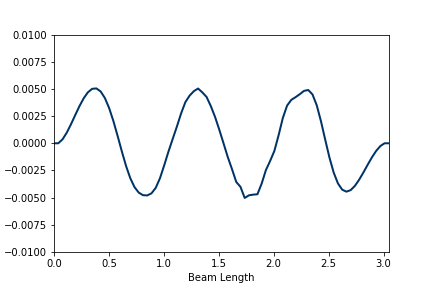
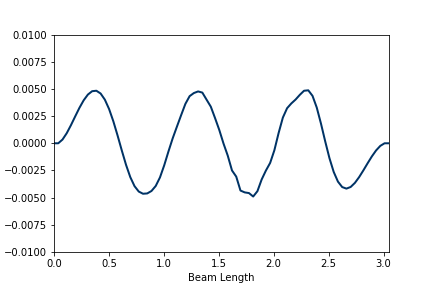
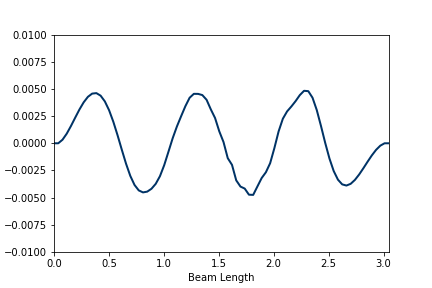
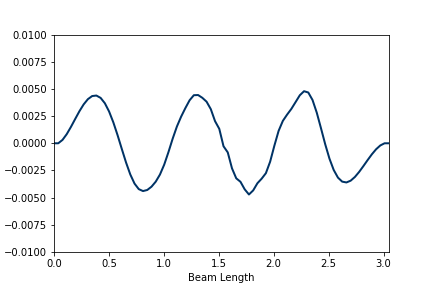
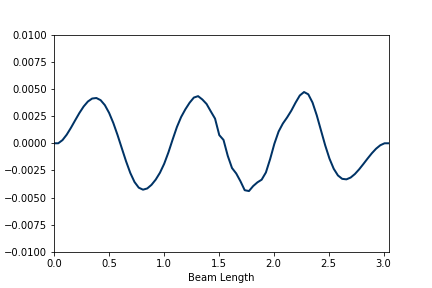
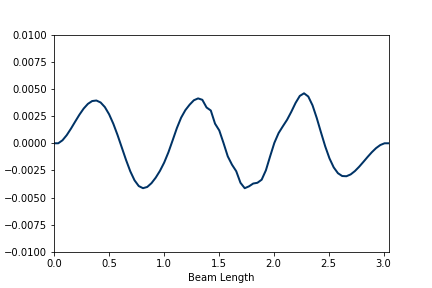
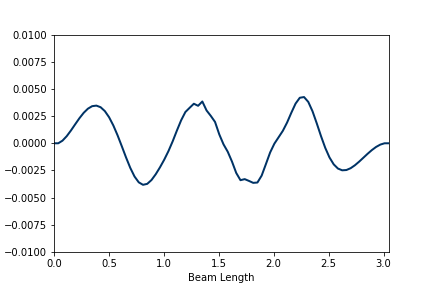
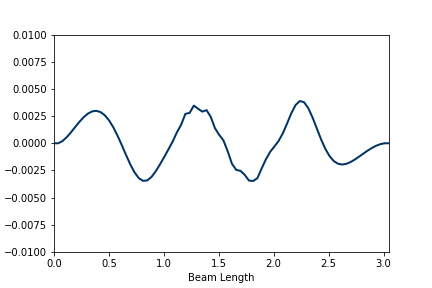
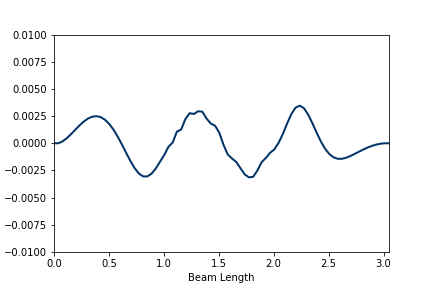
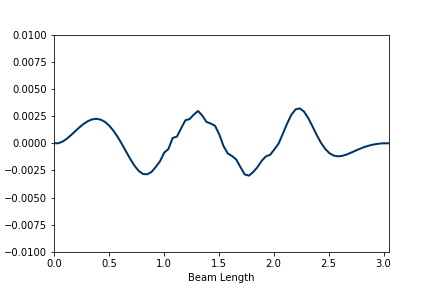
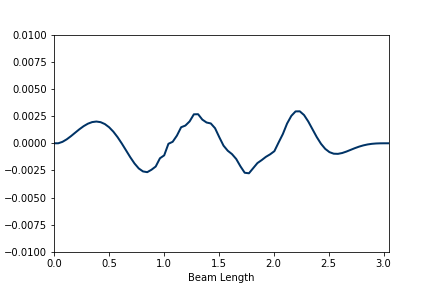
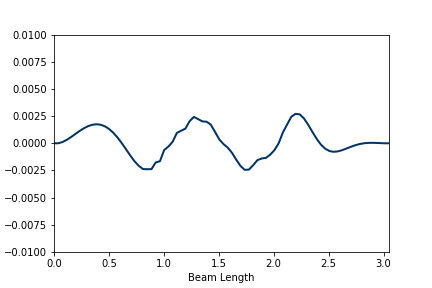
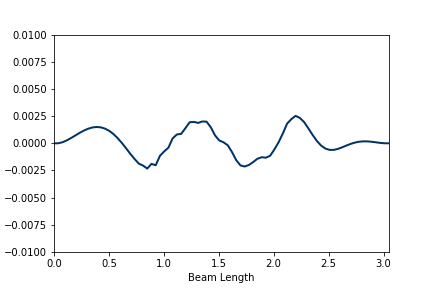
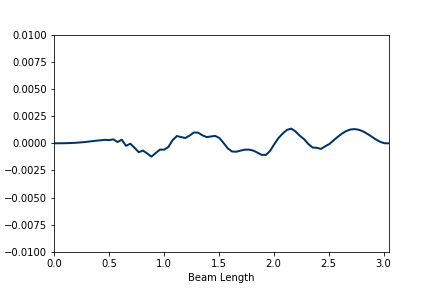
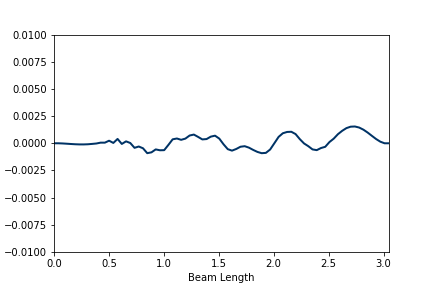
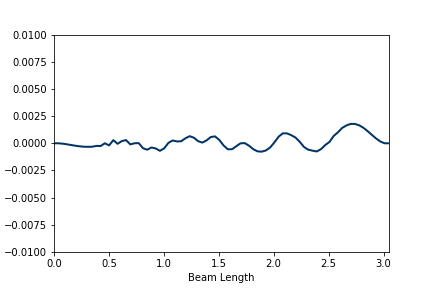
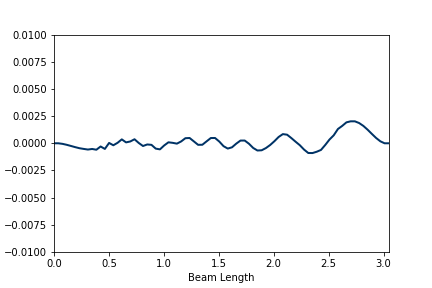
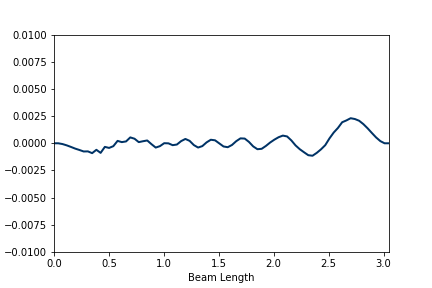
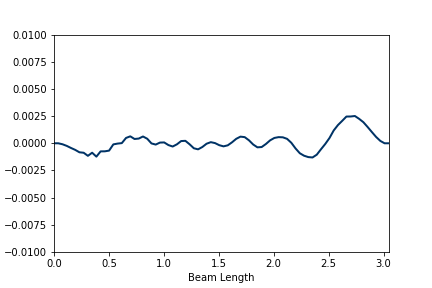
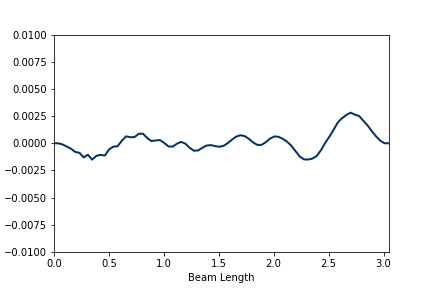
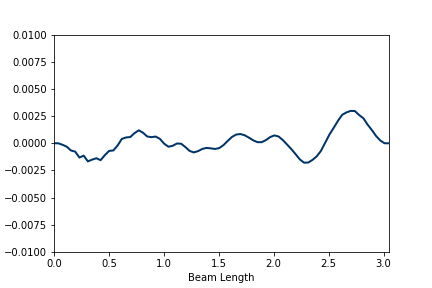
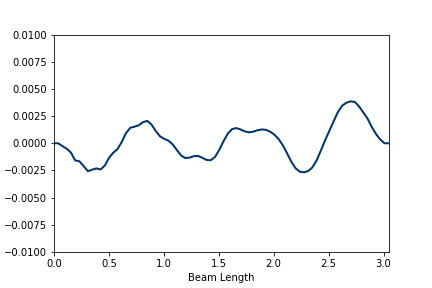
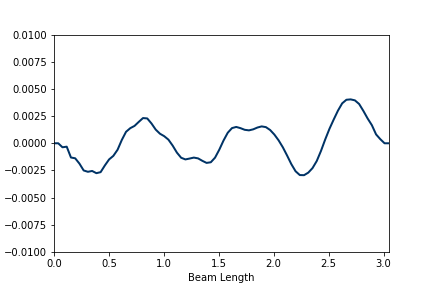
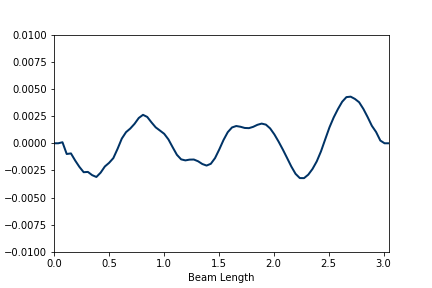
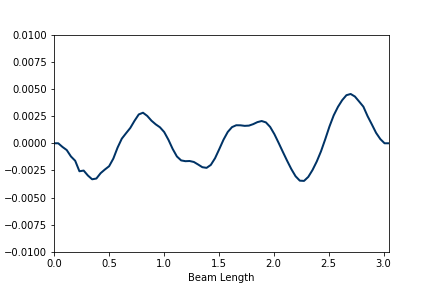
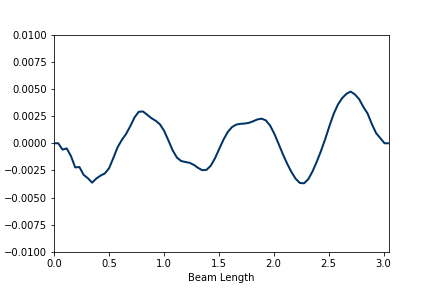
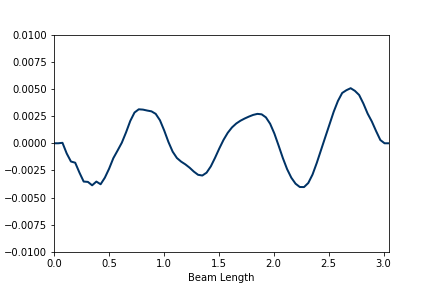
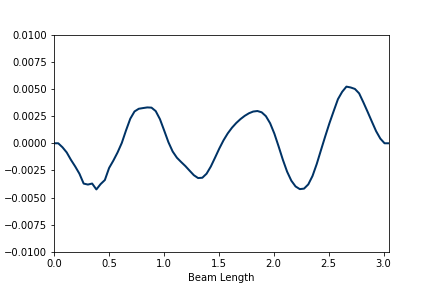
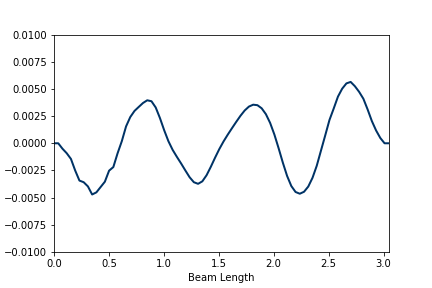
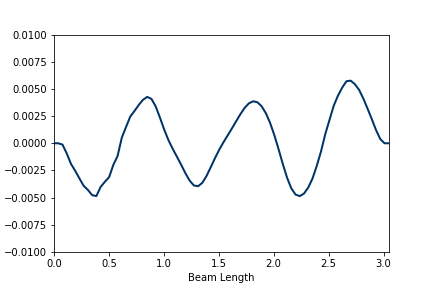
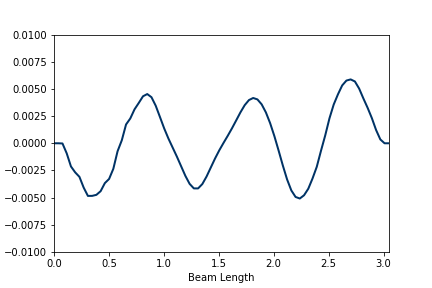
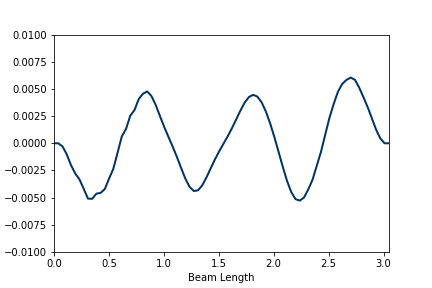
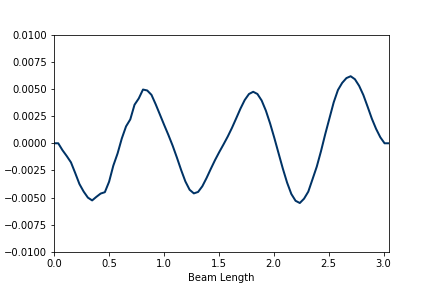
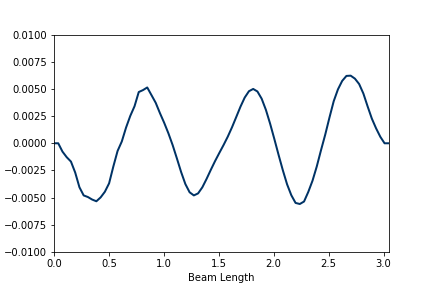
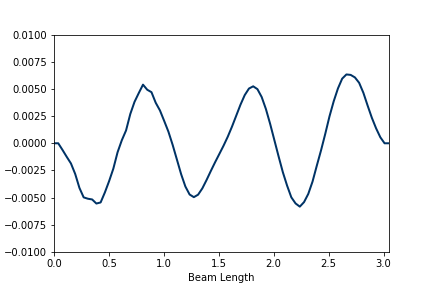
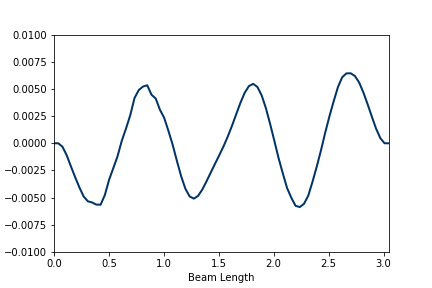
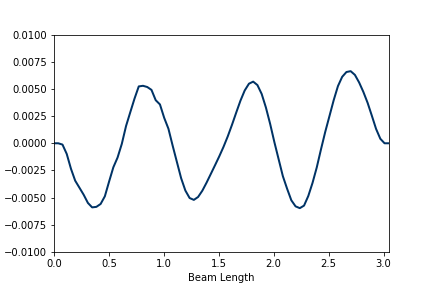
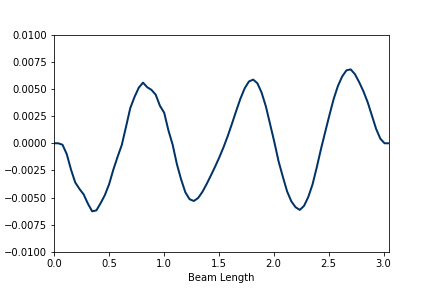
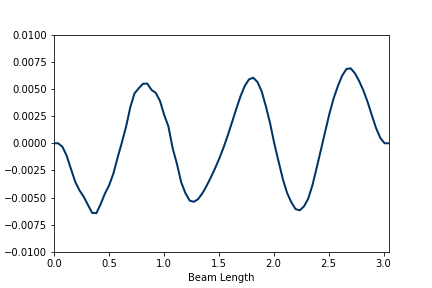
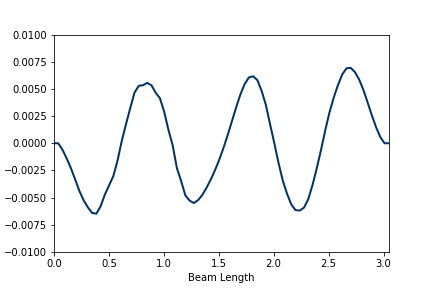
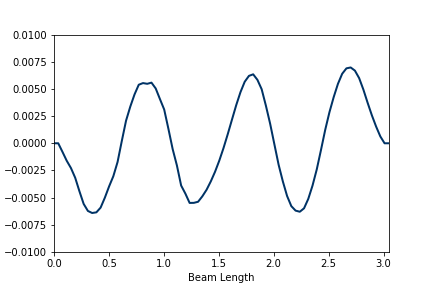
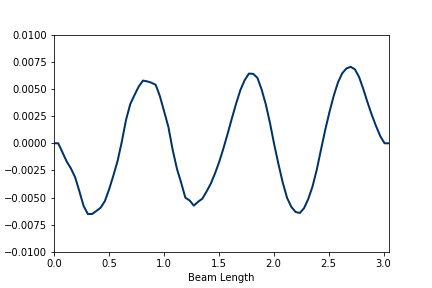
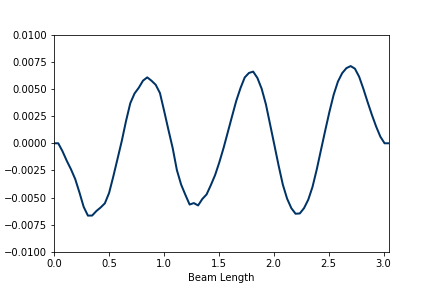
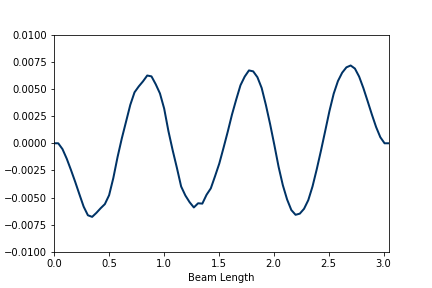
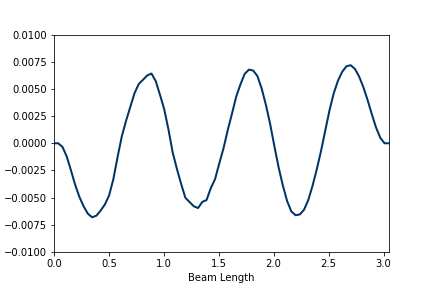
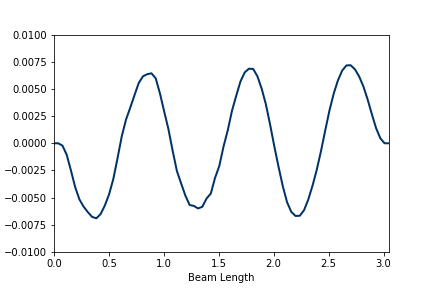
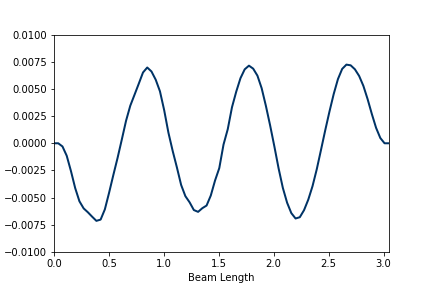
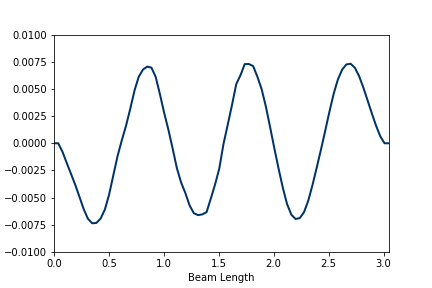
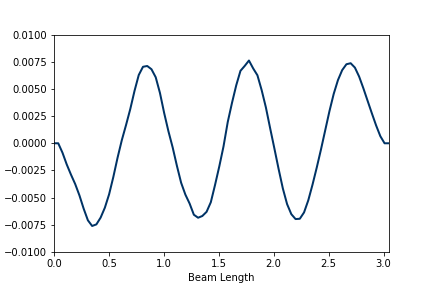
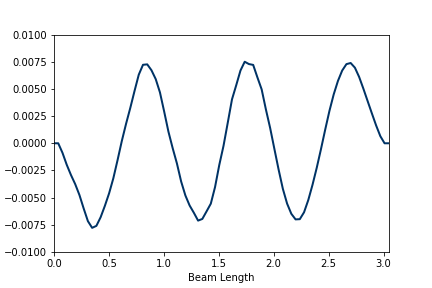
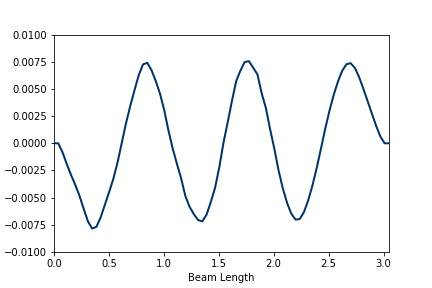
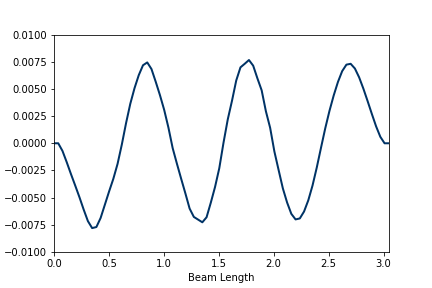
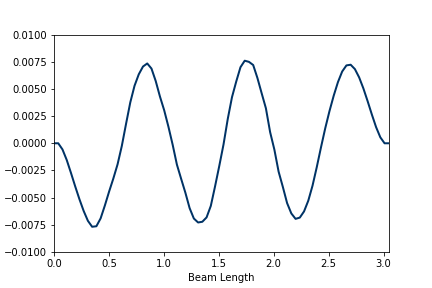
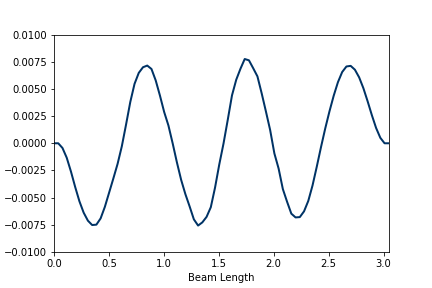
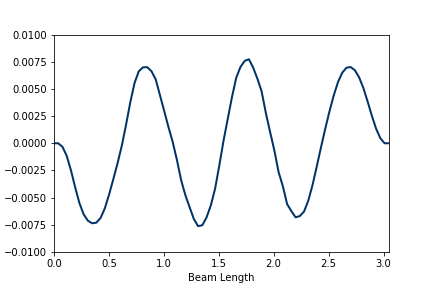
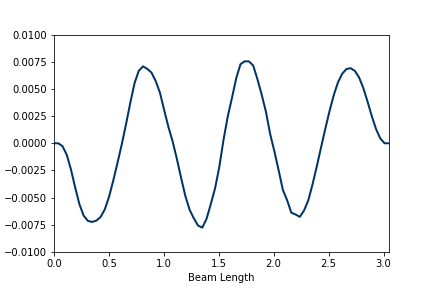
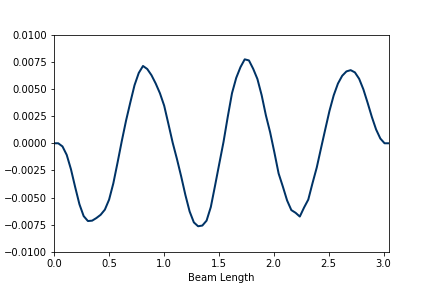
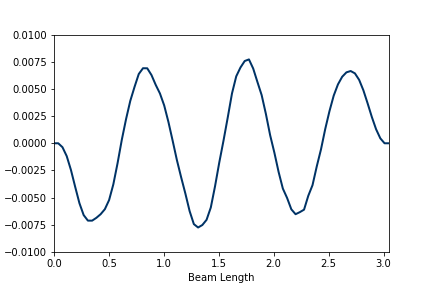

In [14]:
fig = plt.figure();
ax = plt.axes(xlim=(0,3.048),ylim=(-.01,.01),xlabel=('Beam Length'),ylabel=('Beam Displacement'));
line, = ax.plot([],[],color='#003366', lw=2);

def animate(frame):
    x = numpy.linspace(0,L,nx)
    y = w[frame,:]
    line.set_data(x,y)
    return line,

anim = animation.FuncAnimation(fig, animate, frames=nt-1, interval=50)
display_animation(anim, default_mode='once')
#display_animation(anim, default_mode='once')

Whoa, it worked! How neat is that?! Only one mode, the sixth mode, is activated over the entire steel beam. We could do this for any number of modes by solving for a $\beta$ and $\omega$ that correspond to the desired mode.

If you look very carefully, you can see the first step's displacement traversing from the right boundary condition towards the left. It fizzles out fairly quickly, though. This is not a physicality of our system; it is an numerical error that is introduced from our initial "kickstart" of the discretization scheme.

Do you notice the numerical oscillations at the peaks amplitudes of the vibrations waves? Is this because it is a second order accurate method?

##### Dig Deeper

We said that a notable weakness of our design was that it afforded us only a very small step in time, $\Delta t$. In order to run this equation several orders of magnitude longer from 1.347ms to say, 1-10 sconds, significantly more computational time is required.

Have we learned a numerical technique that could be applied here? What about an implicit solution like:

\begin{equation} w_i^{n+1} =  -\frac{b^2\Delta t^2}{\Delta x^4 }(w_{i+2}^{n+1} - 4(w_{i+1}^{n+1} + w_{i-1}^{n+1})+ 6w_{i}^{n+1} + w_{i-2}^{n+1})  + 2w_{i}^n - w_{i}^{n-1}\end{equation}

Your challenge is to design a function that computes the solution for the updated solution at $w^{n+1}$ , i.e. an implicit solution for the Euler-Bernoulli equation. 

## References

1. Anderson, Jr., John D. _"Computational Fluid Dynamics: The Basics with Applications"_, McGraw-Hill, Inc., Singapore, 1995.

2. Barba, Lorena A., et al. "MAE 6286 Practical Numerical Methods with Python," GW Open edX, The George Washingtion University, 2014. http://openedx.seas.gwu.edu/courses/GW/MAE6286/2014_fall/about .

3. Harris, Cyril M. _"Shock and Vibration Handbook, Third Edition"_, McGraw-Hill, Inc., United States of America, 1988.

4. Inman, Daniel J. _"Engineering Vibration Third Edition",_ Pearson Education, Inc., Upper Saddle River, NJ, 2008

5. Strikwerda, John C. _"Finite Difference Schemes and Partial Differential Equations"_, Wadsworth & Brooks/Cole Advanced Books & Software, Belmont, CA, 1989.

6. Young, Warren C. _"Roark's Formulas for Stress and Strain, Sixth Edition"_, McGraw-Hill, Inc., United States of America, 1989.

In [2]:
from IPython.core.display import HTML
css_file = 'H:/Matt/Dropbox/Python/numericalmoocstyle.css'
HTML(open(css_file, "r").read())